In [7]:
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy import CtaTemplate
import talib as ta
import numpy as np

########################################################################
# 策略继承CtaTemplate
class MultiFrameMaStrategy(CtaTemplate):
    className = 'Overshoot'
    author = 'Wang_Yue'
    
    # 策略参数
    lot = 10000
    period = 24
    longperiod = 60
    
    # 策略变量
    maTrend = {} # 记录趋势状态，多头1，空头-1
    transactionPrice = {} # 记录成交价格
    Stoptracking = {} #记录量是否增长
    
    # 参数列表，保存了参数的名称
    paramList = [
                 'RSIPeriodfast',
                 'RSIPeriodslow',
                 'Cortime',
                 'stopRatio',
                 'stdparam'
                ]    
    
    # 变量列表，保存了变量的名称
    varList = [
               'Stoptracking',
               'transactionPrice'
              ]  
    
    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    #----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super().__init__(ctaEngine, setting)
    
    #----------------------------------------------------------------------
    def onInit(self):
        """初始化策略"""
        self.writeCtaLog(u'策略初始化')
        self.transactionPrice = {s:0 for s in self.symbolList} # 生成成交价格的字典
        self.maTrend = {s:0 for s in self.symbolList}
        self.putEvent()

    #----------------------------------------------------------------------
    def onStart(self):
        """启动策略"""
        self.writeCtaLog(u'策略启动')
        self.putEvent()
    
    #----------------------------------------------------------------------
    def onStop(self):
        """停止策略"""
        self.writeCtaLog(u'策略停止')
        self.putEvent()
        
    #----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送"""
        pass
    
    #----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送"""
        self.onBarStopLoss(bar)

    def onBarStopLoss(self, bar):
        symbol = bar.vtSymbol
        if symbol not in self.Stoptracking.keys():
            self.Stoptracking[symbol] = 0.04
        # 计算止损止盈价位
        longStop = self.transactionPrice[symbol]*(1-self.Stoptracking[symbol])
        longProfit = self.transactionPrice[symbol]*(1+5*self.Stoptracking[symbol])
        shortStop = self.transactionPrice[symbol]*(1+self.Stoptracking[symbol])
        shortProfit = self.transactionPrice[symbol]*(1-5*self.Stoptracking[symbol])
        
        
        # 洗价器
        if (self.posDict[symbol+'_LONG'] > 0):
            if (bar.close < longStop):
                print('LONG stopLoss')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.lot)
            elif  (bar.close > longProfit):
                print('LONG takeProfit')
                self.cancelAll()
                self.sell(symbol,bar.close*0.99, self.lot)

        elif (self.posDict[symbol+'_SHORT'] > 0):
            if (bar.close > shortStop):
                print('SHORT stopLoss')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.lot)
            elif (bar.close < shortProfit):
                print('SHORT takeProfit')
                self.cancelAll()
                self.cover(symbol,bar.close*1.01, self.lot)

    #----------------------------------------------------------------------
    def on15MinBar(self, bar):
        """收到60MinBar推送"""
        symbol = bar.vtSymbol
        
        am15 = self.getArrayManager(symbol, "15m")
        
        if not am15.inited:
            return
        gap = (am15.close - am15.open)
        mu = sum(np.abs(gap[-self.period:]))/self.period
        std = np.std(np.abs(gap[-self.period:]))
        current = gap[-1]
        longma = ta.EMA(am15.close,self.longperiod)
        angel = ta.LINEARREG_ANGLE(longma,5)
        #volmu = sum(am15.volume[-self.period:])/self.period
        #volstd = np.std(am15.volume[-self.period:])
        #volcur = am15.volume[-1]
        #engulfing = max(am15.close[-1],am15.open[-1])>max(am15.close[-2],am15.open[-2]) and min(am15.close[-1],am15.open[-1])<min(am15.close[-2],am15.open[-2])
        if current>0 and (current>(mu+4*std)) and angel[-1]>0:
            # 做多信号
            if  (self.posDict[symbol+'_SHORT']==0)and(self.posDict[symbol+'_LONG']==0):
                self.buy(symbol, bar.close*1.01, self.lot)  # 成交价*1.01发送高价位的限价单，以最优市价买入进场
            # 如果有空头持仓，则先平空，再做多
            elif self.posDict[symbol+'_SHORT'] > 0:
                self.cancelAll() # 撤销挂单
                self.cover(symbol, bar.close*1.01, self.posDict[symbol+'_SHORT']) 
                self.buy(symbol, bar.close*1.01, self.lot)
            self.Stoptracking[symbol] = np.abs(current)*0.4
        # 做空信号
        elif current<0 and (np.abs(current)>(mu+4*std)) and angel[-1]<0:
            if (self.posDict[symbol+'_LONG']==0)and(self.posDict[symbol+'_SHORT']==0):
                self.short(symbol, bar.close*0.99, self.lot) # 成交价*0.99发送低价位的限价单，以最优市价卖出进场
            elif self.posDict[symbol+'_LONG'] > 0:
                self.cancelAll() # 撤销挂单
                self.sell(symbol, bar.close*0.99, self.posDict[symbol+'_LONG'])
                self.short(symbol, bar.close*0.99, self.lot)
            self.Stoptracking[symbol] = np.abs(current)*0.4
        self.putEvent()
    
    
    #----------------------------------------------------------------------
    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass
    
    #----------------------------------------------------------------------
    def onTrade(self, trade):
        """收到成交推送（必须由用户继承实现）"""
        symbol = trade.vtSymbol
        if trade.offset == OFFSET_OPEN:  # 判断成交订单类型
            self.transactionPrice[symbol] = trade.price # 记录成交价格
            print(trade.tradeTime, self.posDict)
    #----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass


In [8]:
from vnpy.trader.app.ctaStrategy import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

仓位字典构造完成 
初始仓位: {'EOSUSDT:binance_LONG': 0, 'EOSUSDT:binance_SHORT': 0}
[DEBUG] 注册品种EOSUSDT:binance上的on_15Min_bar函数functools.partial(<function MultiFrameMaStrategy.on15MinBar at 0x12ec04e18>, <__main__.MultiFrameMaStrategy object at 0x12df10400>)
[DEBUG] 注册品种EOSUSDT:binance上的on_1m_bar函数functools.partial(<function MultiFrameMaStrategy.onBar at 0x12eb0aea0>, <__main__.MultiFrameMaStrategy object at 0x12df10400>)
2018-12-12 22:15:25.900649	开始回测
2018-12-12 22:15:25.900720	策略初始化
2018-12-12 22:15:25.903450	载入历史数据。数据范围:[20180623 04:00,20180701 12:00)
2018-12-12 22:15:26.445073	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-12 22:15:26.447996	载入完成，数据量：11295
2018-12-12 22:15:26.448319	策略初始化完成
2018-12-12 22:15:26.448529	策略启动完成
2018-12-12 22:15:26.448623	开始回放回测数据,回测范围:[20180701 12:00,20181121 12:00)
2018-12-12 22:15:26.471450	载入历史数据。数据范围:[20180701 12:00,20181121 12:00)
2018-12-12 22:15:37.743174	 当前品种 EOSUSDT:binance 的数据，全部来自于本地缓存
2018-12-12 22:15:37.804570	载入完成，数据量：204833
2018-12-12 22:15:37.804949

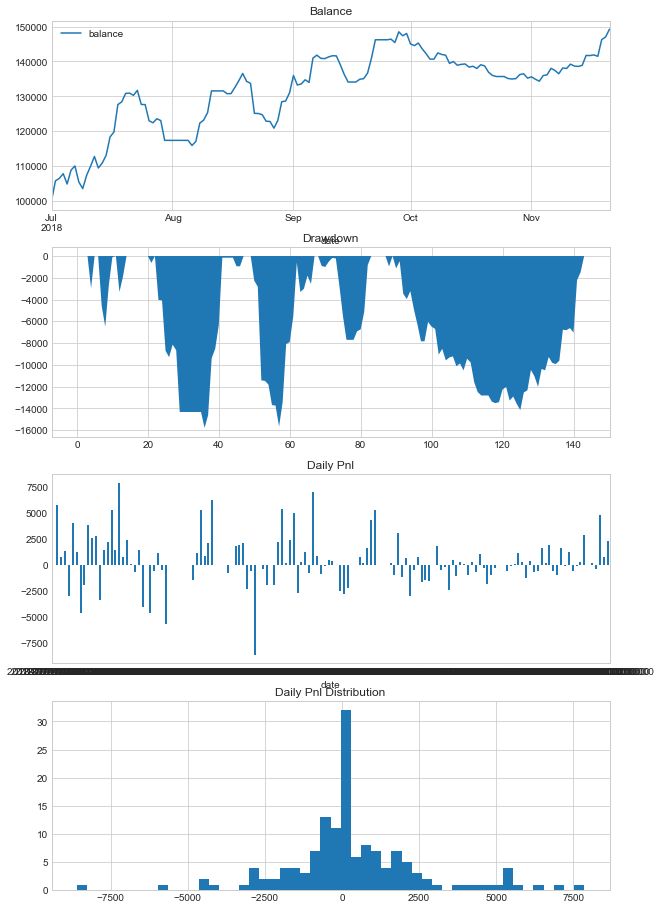

2018-12-12 22:15:59.811184	计算回测结果
2018-12-12 22:15:59.816995	------------------------------
2018-12-12 22:15:59.817218	第一笔交易：	2018-07-05 07:00:00
2018-12-12 22:15:59.817381	最后一笔交易：	2018-11-21 11:58:00
2018-12-12 22:15:59.817447	总交易次数：	38
2018-12-12 22:15:59.817513	总盈亏：	49,220.89
2018-12-12 22:15:59.817574	最大回撤: 	-11,916.93
2018-12-12 22:15:59.817631	平均每笔盈利：	1,295.29
2018-12-12 22:15:59.817684	平均每笔滑点：	40.0
2018-12-12 22:15:59.817730	平均每笔佣金：	61.08
2018-12-12 22:15:59.817777	胜率		42.11%
2018-12-12 22:15:59.817825	盈利交易平均值	6,497.05
2018-12-12 22:15:59.817870	亏损交易平均值	-2,487.81
2018-12-12 22:15:59.817917	盈亏比：	2.61


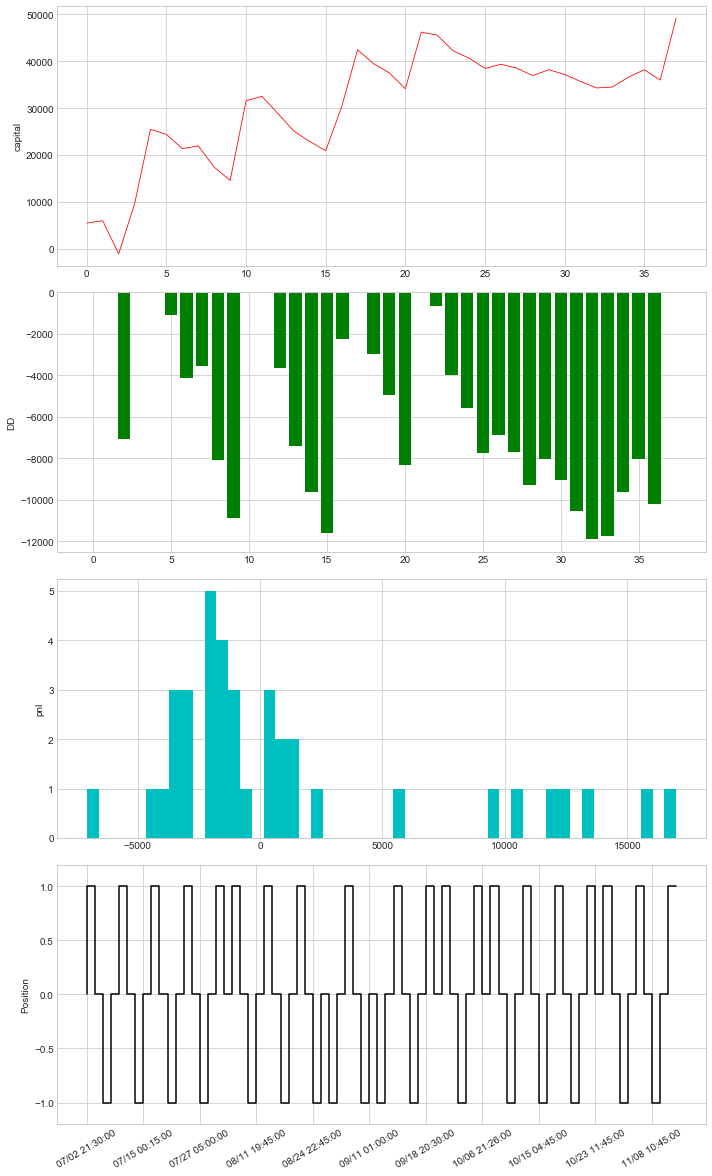

2018-12-12 22:16:01.248419	计算按日统计结果


(               netPnl  slippage  commission  turnover  tradeCount  tradingPnl  \
 date                                                                            
 2018-07-01     0.0000       0.0      0.0000       0.0           0         0.0   
 2018-07-02  5762.2780      20.0     41.7220   83444.0           1      5824.0   
 2018-07-03   722.0000       0.0      0.0000       0.0           0         0.0   
 2018-07-04  1355.0000       0.0      0.0000       0.0           0         0.0   
 2018-07-05 -2968.0220      40.0     89.0220  178044.0           2     -1032.0   
 2018-07-06  3979.0000       0.0      0.0000       0.0           0         0.0   
 2018-07-07  1207.0000       0.0      0.0000       0.0           0         0.0   
 2018-07-08 -4604.3830      40.0     88.3830  176766.0           2      -890.0   
 2018-07-09 -1887.0000       0.0      0.0000       0.0           0         0.0   
 2018-07-10  3801.5630      40.0     81.4370  162874.0           2     17074.0   
 2018-07-11  257

In [9]:
parameterDict = {'symbolList':['EOSUSDT:binance']}
runBacktesting(MultiFrameMaStrategy, parameterDict, '20180701 12:00', '20181121 12:00', 0.002, 5/10000)